In [1]:
!python --version

Python 3.11.11


In [6]:
!pip install paddlepaddle-gpu
!pip install paddleocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 759.0/759.0 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: opt-einsum
    Found existing installation: opt_einsum 3.4.0
    Uninstalling opt_einsum-3.4.0:
      Successfully uninstalled opt_einsum-3.4.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.8/297.8 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 47.3 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=b9fc8b68007fb7051c4b172bfe56b366f78498cd8317f935b6c858ad6bd20b2a
  Stored 

In [1]:
!git clone https://github.com/PaddlePaddle/PaddleOCR.git
%cd PaddleOCR


Cloning into 'PaddleOCR'...
remote: Enumerating objects: 126732, done.
remote: Counting objects: 100% (8308/8308), done.
remote: Compressing objects: 100% (925/925), done.
remote: Total 126732 (delta 7907), reused 7545 (delta 7383), pack-reused 118424 (from 3)
Receiving objects: 100% (126732/126732), 760.32 MiB | 23.22 MiB/s, done.
Resolving deltas: 100% (98264/98264), done.
Updating files: 100% (2028/2028), done.
/content/PaddleOCR


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터 전처리

In [12]:
import json
import os
import glob


In [14]:
# 이미지 파일 이름 통일
directory = "/content/drive/MyDrive/Colab Notebooks/images"

# 디렉토리 내의 모든 파일 목록 가져오기
files = os.listdir(directory)

# 파일 이름 변경 로직 (예시: 모든 파일 이름 앞에 "new_" 추가)
for filename in files:
    old_filepath = os.path.join(directory, filename)
    new_filename = filename.replace("JPG","jpg")
    new_filepath = os.path.join(directory, new_filename)
    os.rename(old_filepath, new_filepath)

### 학습 데이터

In [35]:
def convert_json_to_paddleocr_det(json_label_path, images_file_path, output_label_path):
    """
    JSON annotation 파일을 PaddleOCR detection 학습용 라벨 파일로 변환합니다.

    Args:
        json_label_path (str): JSON 라벨 파일들이 있는 디렉토리 경로.
        images_file_path (str): 이미지 파일들이 있는 디렉토리 경로.
        output_label_path (str): 생성될 PaddleOCR 라벨 파일 경로.
    """
    with open(output_label_path, "w", encoding="utf-8") as output_file:
        # JSON 파일 목록 가져오기
        json_files = glob.glob(os.path.join(json_label_path, "*.json"))

        for json_file in json_files:
            # JSON 파일 열기
            with open(json_file, "r", encoding="utf-8") as f:
                data = json.load(f)

            # 이미지 정보 추출
            image_info = data["images"][0]  # images는 리스트이지만, 일반적으로 첫 번째 요소에 이미지 정보가 있음
            image_filename = image_info["file_name"].replace("JPG","jpg")
            image_path = os.path.join(images_file_path, image_filename)

            # PaddleOCR 라벨 형식의 annotation 리스트 생성
            annotations_paddleocr = []
            for annotation in data["annotations"]:
                # bounding box 좌표 추출 (xmin, ymin, xmax, ymax)
                bbox = annotation["bbox"]
                xmin, ymin, xmax, ymax = bbox[0], bbox[1], bbox[2], bbox[3]

                # PaddleOCR points 형식으로 변환: [[x1, y1], [x2, y2], [x3, y3], [x4, y4]] (시계 방향)
                points = [
                    [xmin, ymin],
                    [xmax, ymin],
                    [xmax, ymax],
                    [xmin, ymax]
                ]

                # transcription 과 points 정보를 annotation 딕셔너리에 저장
                annotation_paddleocr = {
                    "transcription": annotation["text"],
                    "points": points
                }
                annotations_paddleocr.append(annotation_paddleocr)

            # PaddleOCR 라벨 형식 (JSON list) 문자열로 변환
            label_json_str = json.dumps(annotations_paddleocr, ensure_ascii=False)

            # 라벨 파일 라인 생성 (이미지 경로 \t JSON 문자열)
            label_line = f"{image_path}\t{label_json_str}\n"

            # 파일에 저장
            output_file.write(label_line)


In [43]:
json_label_path = "/content/drive/MyDrive/ColabNotebooks/book_cover_data_label"  # JSON 라벨 파일 경로 (본인 환경에 맞게 수정)
images_file_path = "/content/drive/MyDrive/ColabNotebooks/images"     # 이미지 파일 경로 (본인 환경에 맞게 수정)
output_label_path = "/content/drive/MyDrive/ColabNotebooks/label/train_label.txt" # 출력될 train_label.txt 파일 경로 (본인 환경에 맞게 수정)

convert_json_to_paddleocr_det(json_label_path, images_file_path, output_label_path)

### Eval data

In [44]:
images_file_path = '/content/drive/MyDrive/ColabNotebooks/evel_images'
json_label_path = "/content/drive/MyDrive/ColabNotebooks/evel_book_cover_data"
output_label_path = "/content/drive/MyDrive/ColabNotebooks/evel_label/evel_label.txt"

convert_json_to_paddleocr_det(json_label_path, images_file_path, output_label_path)

### 사전학습 모델 가져오기

In [16]:
!mkdir -p /content/drive/MyDrive/Colab Notebooks/pretrained
!wget -P /content/drive/MyDrive/Colab Notebooks/pretrained https://paddleocr.bj.bcebos.com/pretrained/MobileNetV3_large_x0_5_pretrained.pdparams

--2025-03-07 10:33:35--  http://notebooks/pretrained
Resolving notebooks (notebooks)... failed: Name or service not known.
wget: unable to resolve host address ‘notebooks’
--2025-03-07 10:33:35--  https://paddleocr.bj.bcebos.com/pretrained/MobileNetV3_large_x0_5_pretrained.pdparams
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 103.235.47.176, 2402:2b40:7000:628:0:ff:b0e8:88da
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|103.235.47.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3189601 (3.0M) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/Colab/MobileNetV3_large_x0_5_pretrained.pdparams’

MobileNetV3_large_x 100%[===================>]   3.04M   612KB/s    in 15s     

2025-03-07 10:33:52 (213 KB/s) - ‘/content/drive/MyDrive/Colab/MobileNetV3_large_x0_5_pretrained.pdparams’ saved [3189601/3189601]

FINISHED --2025-03-07 10:33:52--
Total wall clock time: 18s
Downloaded: 1 files, 3.0M in 15s (213 KB/s)


### Model training

In [54]:
!python3 tools/train.py -c "/content/PaddleOCR/configs/det/ch_PP-OCRv3/ch_PP-OCRv3_det_student.yml"

[2025/03/07 12:29:56] ppocr WARNING: Skipping import of the encryption module.
[2025/03/07 12:29:56] ppocr INFO: Architecture : 
[2025/03/07 12:29:56] ppocr INFO:     Backbone : 
[2025/03/07 12:29:56] ppocr INFO:         disable_se : True
[2025/03/07 12:29:56] ppocr INFO:         model_name : large
[2025/03/07 12:29:56] ppocr INFO:         name : MobileNetV3
[2025/03/07 12:29:56] ppocr INFO:         scale : 0.5
[2025/03/07 12:29:56] ppocr INFO:     Head : 
[2025/03/07 12:29:56] ppocr INFO:         k : 50
[2025/03/07 12:29:56] ppocr INFO:         name : DBHead
[2025/03/07 12:29:56] ppocr INFO:     Neck : 
[2025/03/07 12:29:56] ppocr INFO:         name : RSEFPN
[2025/03/07 12:29:56] ppocr INFO:         out_channels : 96
[2025/03/07 12:29:56] ppocr INFO:         shortcut : True
[2025/03/07 12:29:56] ppocr INFO:     Transform : None
[2025/03/07 12:29:56] ppocr INFO:     algorithm : DB
[2025/03/07 12:29:56] ppocr INFO:     model_type : det
[2025/03/07 12:29:56] ppocr INFO: Eval : 
[2025/03/

### Loss 변화율

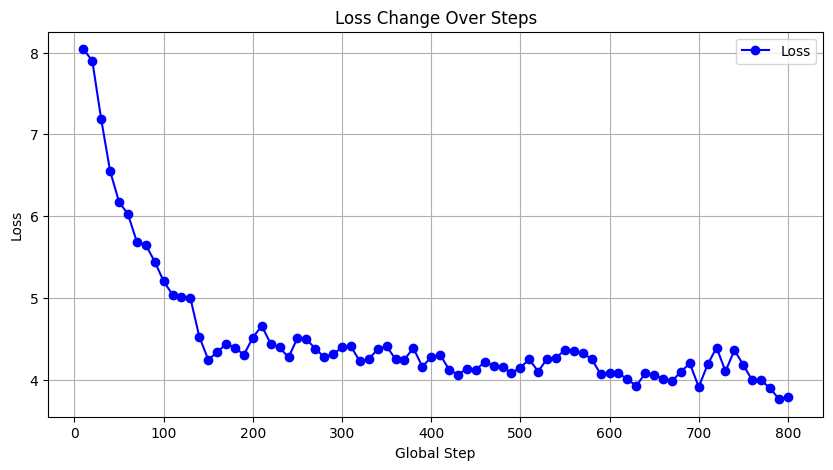

In [55]:
import re
import matplotlib.pyplot as plt

# 로그 파일 경로
log_file_path = "/content/drive/MyDrive/ColabNotebooks/log.txt"

# 손실(loss) 값과 스텝(global_step) 값을 저장할 리스트
steps = []
losses = []

# 정규 표현식 패턴: global_step과 loss 값 추출
pattern = re.compile(r"global_step: (\d+), .*?loss: ([\d.]+)")

# 로그 파일 읽기 및 데이터 추출
with open(log_file_path, "r") as file:
    for line in file:
        match = pattern.search(line)
        if match:
            step = int(match.group(1))
            loss = float(match.group(2))
            steps.append(step)
            losses.append(loss)

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, marker='o', linestyle='-', color='b', label='Loss')

plt.xlabel("Global Step")
plt.ylabel("Loss")
plt.title("Loss Change Over Steps")
plt.legend()
plt.grid(True)
plt.show()


## Finetuned 모델 추론

In [2]:
import os
import paddle
from paddleocr import PaddleOCR, draw_ocr


/usr/local/lib/python3.11/dist-packages/paddle/base/framework.py:688: UserWarning: You are using GPU version Paddle, but your CUDA device is not set properly. CPU device will be used by default.
  warnings.warn(


In [5]:
finetuned_model_path = "/content/output/ch_PP-OCR_V3_det/latest"

ocr = PaddleOCR(det_model_dir = finetuned_model_path,
                use_angle_cls=False,
                lang='korean',
                rec_model_dir=None,
                # 필요에 따라 설정 유지 또는 제거
                )

[2025/03/08 07:41:01] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/content/output/ch_PP-OCR_V3_det/latest', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/korean/korean_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_len

In [30]:
# 이미지 경로 설정 (기존 코드 유지)
image_path = "/content/drive/MyDrive/comparison_images/"
book_cover_images = ['책표지_총류_000002.jpg','책표지_총류_000085.jpg','책표지_총류_000102.jpg','책표지_총류_000292.jpg','책표지_총류_000586.jpg']

for i in range(5):
  images_file_path = image_path + book_cover_images[i]
  ocr_result = ocr.ocr(images_file_path, cls=True)

  for line_info in ocr_result[0]:
    text, confidence = line_info[1]  # 튜플에서 텍스트와 신뢰도 추출
    print(text)     # 텍스트만 리스트에 추가


[2025/03/08 08:05:05] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2025/03/08 08:05:05] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.23780274391174316
[2025/03/08 08:05:06] ppocr DEBUG: rec_res num  : 4, elapsed : 0.693303108215332
시나리오
플래닝
유정식
지음
[2025/03/08 08:05:06] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2025/03/08 08:05:06] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.23000502586364746
[2025/03/08 08:05:08] ppocr DEBUG: rec_res num  : 11, elapsed : 1.7819721698760986
타파할
난독
시대를
독서의기술
혼자
읽기부터
북클럽
참여까지
독서
뉴얼
실전
[2025/03/08 08:05:08] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2025/03/08 08:05:09] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2218952178955078
[2025/03/08 08:05:09] ppocr DEBUG: rec_res num  : 3, elapsed : 0.4898366928100586
로큰롤의
유산을
찾아서
[2025/03/08 08:05:09] ppocr WARNING: Sin

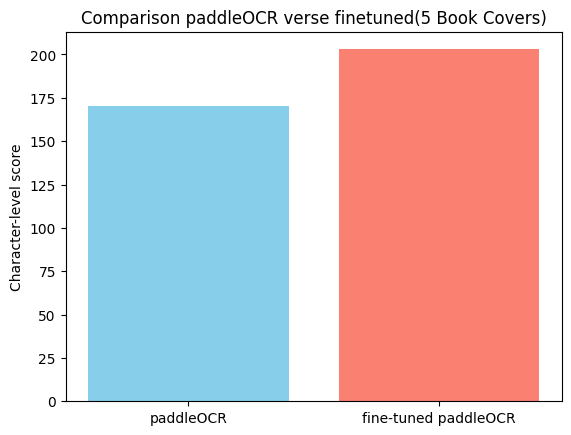

In [3]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

ocrs = ['paddleOCR','fine-tuned paddleOCR']
values = [170, 203]
colors = ['skyblue', 'salmon']  # 각 막대별 색상 리스트

ax.bar(ocrs, values, color=colors)

ax.set_ylabel('Character-level score')
ax.set_title('Comparison paddleOCR verse finetuned(5 Book Covers)')

plt.show()